# Clasificador de Imagenes

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import os
import shutil
import pickle

2025-11-24 00:33:57.323072: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-24 00:33:57.344536: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-24 00:33:58.236510: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-24 00:34:01.404252: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [3]:
# Carpeta donde están todas las imágenes mezcladas
imagenes = "train"

In [4]:
imagenes = "train"  
print("Ruta existe?", os.path.exists('train'))
print("Contenido:", os.listdir('train'))

Ruta existe? True
Contenido: ['cat', 'dog']


Division de las imagenes en carpetas 

In [5]:
# Carpeta original
imagenes = 'train'

# Crear carpetas para cada clase
cat_dir = os.path.join(imagenes, 'cat')
dog_dir = os.path.join(imagenes, 'dog')
os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)

# Listar todas las imágenes 
all_images = os.listdir(imagenes)

# Mover imágenes a la carpeta correspondiente según su nombre
for img in all_images:
    img_lower = img.lower()
    source_path = os.path.join(imagenes, img)
    
    # Saltar si es ya una carpeta
    if os.path.isdir(source_path):
        continue
    
    if 'cat' in img_lower:
        shutil.move(source_path, os.path.join(cat_dir, img))
    elif 'dog' in img_lower:
        shutil.move(source_path, os.path.join(dog_dir, img))

print("Imágenes organizadas en 'train/cat' y 'train/dog'.")

Imágenes organizadas en 'train/cat' y 'train/dog'.


Visualizacion de las imagenes

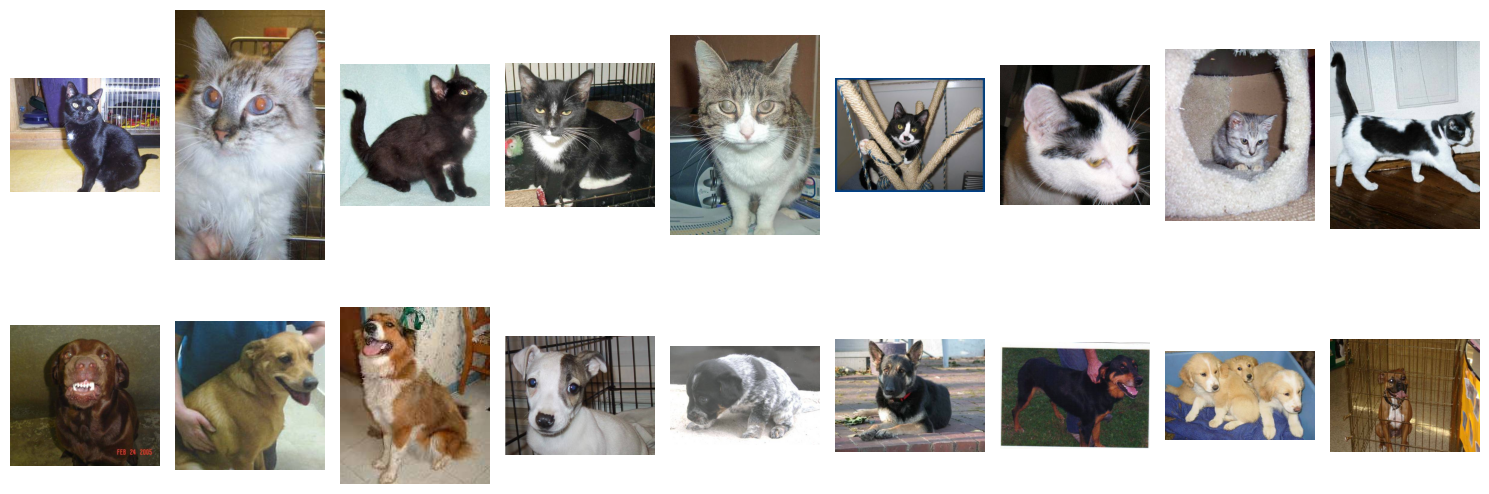

In [6]:
# Ruta de la carpeta principal
ruta_base = "train"
carpetas = ["cat", "dog"]

# Número de imágenes por clase
numero_imagenes = 9

# grafico
fig, axes = plt.subplots(len(carpetas), numero_imagenes, figsize=(15, 6))

for i, clase in enumerate(carpetas):
    ruta_clase = os.path.join(ruta_base, clase)
    lista_imagenes = os.listdir(ruta_clase)[:numero_imagenes] 
    
    for j, img_nombre in enumerate(lista_imagenes):
        img_path = os.path.join(ruta_clase, img_nombre)
        img = mpimg.imread(img_path)
        
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        
        # Etiqueta en la primera columna
        if j == 0:
            axes[i, j].set_ylabel(clase.upper(), fontsize=14)

plt.tight_layout()
plt.show()

Normalizacion, División de imagenes para train y test con validation split

Se prepara los datos para un transfer learing ya que el equipo hardware cacero no soporta un entrenamiento desde 0

In [7]:
# Usamos subset='validation' para cargar el 20% de los dat# Parametros de las imagenes cat y dog 
imagenes = 'train'  
tamano_imagen= (224, 224) #para entrenar con el modelo VGG16
batch_size= 32

#Normalizacion y Division de datos
validation_split = 0.2 # 20% de las imágenes se usarán para test

# Se crea un solo objeto con la normalización y aumento de datos, rescale hace normalizacion 0-1 y rotation_range le aumenta los datos para el entrenamiento
datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, horizontal_flip=True, zoom_range=0.2, validation_split=validation_split) # Validation_split ya divide los datos de test

# Usamos subset='training' para cargar el 80% de los datos
train_generator = datagen.flow_from_directory(imagenes, target_size=tamano_imagen, batch_size=batch_size, class_mode='categorical', subset='training', shuffle=True)

# Generador de validacion
validation_generator = datagen.flow_from_directory(imagenes, target_size=tamano_imagen, batch_size=batch_size, class_mode='categorical', subset='validation', shuffle=False)

print("--Verificación de Generadores--")
print(f"Clases asignadas: {train_generator.class_indices}")
print(f"Imágenes de entrenamiento cargadas: {train_generator.samples}")
print(f"Imágenes de validación cargadas: {validation_generator.samples}")

Found 10660 images belonging to 2 classes.
Found 2664 images belonging to 2 classes.
--Verificación de Generadores--
Clases asignadas: {'cat': 0, 'dog': 1}
Imágenes de entrenamiento cargadas: 10660
Imágenes de validación cargadas: 2664


Entrenamiento con Transfer learning VGG16 

Se carga el modelo preentrenado VGG16  

In [8]:
#  VGG16 preentrenado se lo carga
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Congelar capas
for layer in base_model.layers:
    layer.trainable = False

# Modelo final
model = Sequential([base_model,Flatten(), Dense(256, activation='relu'),Dropout(0.5),Dense(2, activation='softmax')])

#Compilar modelo - se indica el como debe aprender
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()


2025-11-24 00:34:03.467447: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,986 (80.64 MB)

 Trainable params: 6,423,298 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

#Entrenamiento con imagenes nuevas 

Se entrena el modelo con este codigo:
history = model.fit(train_generator, validation_data=validation_generator, epochs=5)

Se puso 5 Epoch debido a la limitacion del hardware, una macbook. El tiempo de entreno es de 3 horas. 

In [9]:
modelo_imagenes = "modelo_entrenado.keras"

# Verificar si el modelo ya existe
if os.path.exists(modelo_imagenes):
    print("Modelo encontrado. No se entrenará de nuevo.")
    model = tf.keras.models.load_model(modelo_imagenes)
    skip_training = True
else:
    print("Modelo no encontrado. Se entrenará uno nuevo.")
    skip_training = False

# Entrenamiento solo si el modelo no existe
if not skip_training:
    # Entrenamiento del modelo
    history = model.fit(train_generator, validation_data=validation_generator, epochs=5)

    # Se guarda el modelo entrenado
    model.save(modelo_imagenes)
    print("✔️ Modelo entrenado y guardado como", modelo_imagenes)
else:
    print("✔️ Entrenamiento saltado, modelo cargado desde disco")

Modelo encontrado. No se entrenará de nuevo.
✔️ Entrenamiento saltado, modelo cargado desde disco


In [10]:
#Leer el modelo 
model = load_model("modelo_entrenado.keras")
print(model)

<Sequential name=sequential, built=True>


In [11]:
for layer in model.layers:
    print(layer.name, layer.trainable)

vgg16 True
flatten True
dense True
dropout True
dense_1 True


In [12]:
trainable_count = np.sum([np.prod(v.shape) for v in model.trainable_weights])
non_trainable_count = np.sum([np.prod(v.shape) for v in model.non_trainable_weights])

print("Parámetros entrenables:", trainable_count)
print("Parámetros no entrenables:", non_trainable_count)

Parámetros entrenables: 6423298
Parámetros no entrenables: 14714688


Evaluar modelo 

In [15]:
loss, acc = model.evaluate(validation_generator)
print("Validation Loss:", loss)
print("Validation Accuracy:", acc)

84/84 ━━━━━━━━━━━━━━━━━━━━ 584s 7s/step - accuracy: 0.9002 - loss: 0.2370
Validation Loss: 0.2370270937681198
Validation Accuracy: 0.9001501798629761


Probar el modelo 

In [14]:
# Cargar el modelo
model = load_model("modelo_entrenado.keras")

# Nombres exactos de las imágenes en la raíz
images = ["cat.jpg", "dog.jpg"] 

for img_name in images:
    img_path = img_name  
    
    img = image.load_img(img_path, target_size=(224,224))
    img_array = image.img_to_array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    label = "gato" if pred[0][0] > 0.5 else "perro"
    print(f"{img_name}: {label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
cat.jpg: gato
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
dog.jpg: perro


# Conclusion

El modelo entrenado con las nuevas imagenes de perros y gatos se realizo con transfer learning de VGG16; el mismo que brindo un accuracy de 90% con 5 Epoch. El modelo entrenado con nuevas imagenes dio un accuracy alto y brindo una respuesta acertada con dos imagenes nuevas de perro y gato; es decir pudo reconocer de manera exitosa. 
